# Generating a weighted Monte Carlo lightcone of Diffsky galaxies

This notebook demonstrates how to generate a lightcone of diffsky galaxies with SEDs, star formation histories, dust, and other properties.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from jax import random as jran
ran_key = jran.key(0)

In [2]:
from diffsky.experimental import mc_weighted_lightcone_data

num_halos = 500
z_min, z_max = 0.2, 3.0
lgmp_min, lgmp_max = 10.5, 15.0
sky_area_degsq = 1.0

In [3]:
from dsps.data_loaders import load_ssp_templates
ssp_data = load_ssp_templates()

In [4]:
from dsps.data_loaders.retrieve_fake_fsps_data import load_fake_filter_transmission_curves
from dsps.data_loaders.defaults import TransmissionCurve

_res = load_fake_filter_transmission_curves()
wave, u, g, r, i, z, y = _res

tcurves = [TransmissionCurve(wave, x) for x in (u, g, r, i, z, y)]

In [5]:
n_z_phot_table = 30
z_phot_table = np.linspace(z_min, z_max, n_z_phot_table)

In [6]:
halo_lc_data = (num_halos, z_min, z_max, lgmp_min, lgmp_max, sky_area_degsq)
phot_data = (ssp_data, tcurves, z_phot_table)

args = (ran_key, *halo_lc_data, *phot_data)

lc_data = mc_weighted_lightcone_data(*args)

In [7]:
from diffsky.experimental import mc_weighted_diffsky_lightcone
sed_info = mc_weighted_diffsky_lightcone(ran_key, lc_data)
sed_info._fields

('rest_sed',
 'logmp_obs',
 'logsm_obs',
 'logssfr_obs',
 'sfh_table',
 'obs_mags',
 'diffstar_params',
 'burst_params',
 'dust_params',
 'ssp_weights',
 'frac_ssp_err_sed',
 'ftrans_sed',
 'mc_sfh_type')

#### For the _weighted_ lightcone, each halo has multiplicity according to its abundance in the volume

This `nhalos` column needs to be taken into account when predicting summary statistics from the weighted lightcone.

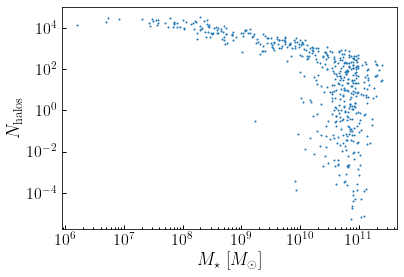

In [8]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.scatter(10**sed_info.logsm_obs, lc_data.nhalos, s=1)
xlabel = ax.set_xlabel(r'$M_{\star}\ [M_{\odot}]$')
ylabel = ax.set_ylabel(r'$N_{\rm halos}$')

#### Calculate the halo mass function, accounting for halo weights

The unweighted version uniformly spans $\log_{10}M_{\rm halo}$. The weighted version has the expected Schechter-type shape of the HMF.

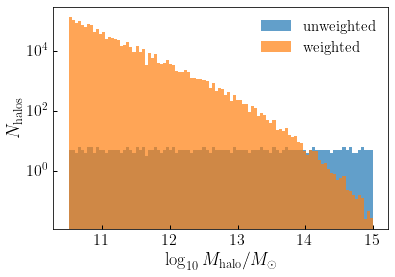

In [9]:
fig, ax = plt.subplots(1, 1)
yscale = ax.set_yscale('log')
__=ax.hist(sed_info.logmp_obs, bins=100, alpha=0.7, label=r'${\rm unweighted}$')
__=ax.hist(sed_info.logmp_obs, bins=100, weights=lc_data.nhalos, alpha=0.7, label=r'${\rm weighted}$')
xlabel = ax.set_xlabel(r'$\log_{10}M_{\rm halo}/M_{\odot}$')
ylabel = ax.set_ylabel(r'$N_{\rm halos}$')
leg = ax.legend()

#### Visually inspect the diversity of SFHs

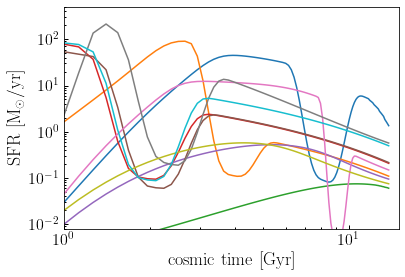

In [10]:
fig, ax = plt.subplots(1, 1)
yscale = ax.set_yscale('log')
ylim = ax.set_ylim(8e-3, 5e2)
xscale = ax.set_xscale('log')
xlim = ax.set_xlim(1, 15)

n_plot = 10
for i in range(n_plot):
    __=ax.plot(lc_data.t_table, sed_info.sfh_table[i, :])

xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'${\rm SFR\ [M_{\odot}/yr]}$')

#### Visually inspect the sSFR PDF

Note that the plot below shows the PDF for _all_ galaxies/halos in the lightcone, without accounting for the weights

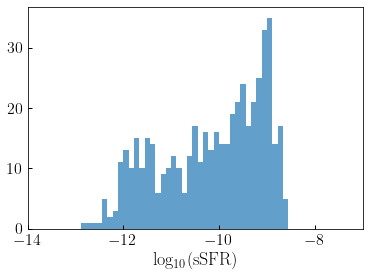

In [11]:
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(-14, -7)
__=ax.hist(sed_info.logssfr_obs, bins=150, alpha=0.7)
xlabel = ax.set_xlabel(r'${\rm log_{10}(sSFR)}$')

#### Visually inspect star-forming sequence

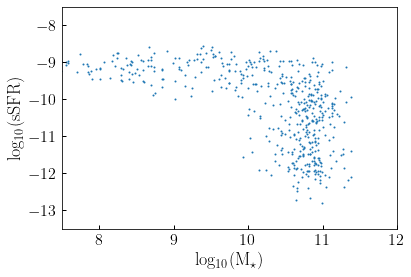

In [12]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(-13.5, -7.5)
xlim = ax.set_xlim(7.5, 12)
__=ax.scatter(sed_info.logsm_obs, sed_info.logssfr_obs, s=1)
xlabel = ax.set_xlabel(r'${\rm log_{10}(M_{\star})}$')
ylabel = ax.set_ylabel(r'${\rm log_{10}(sSFR)}$')

### Plot color-color diagram

Note that the plot below shows the PDF for _all_ galaxies/halos in the lightcone, without accounting for the weights, and without selecting a particular galaxy sample of interest.

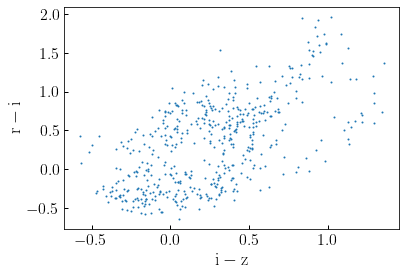

In [13]:
fig, ax = plt.subplots(1, 1)

ri = sed_info.obs_mags[:, 2]-sed_info.obs_mags[:, 3]
iz = sed_info.obs_mags[:, 3]-sed_info.obs_mags[:, 4]
__=ax.scatter(iz, ri, s=1)
xlabel = ax.set_xlabel(r'${\rm i-z}$')
ylabel = ax.set_ylabel(r'${\rm r-i}$')

### Plot color--redshift relation

Note that the plot below shows the PDF for _all_ galaxies/halos in the lightcone, without accounting for the weights, and without selecting a particular galaxy sample of interest.

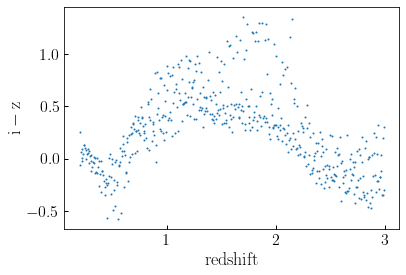

In [14]:
fig, ax = plt.subplots(1, 1)

iz = sed_info.obs_mags[:, 3]-sed_info.obs_mags[:, 4]
__=ax.scatter(lc_data.z_obs, iz, s=1)
xlabel = ax.set_xlabel(r'${\rm redshift}$')
ylabel = ax.set_ylabel(r'${\rm i-z}$')

### Examine diversity of SEDs

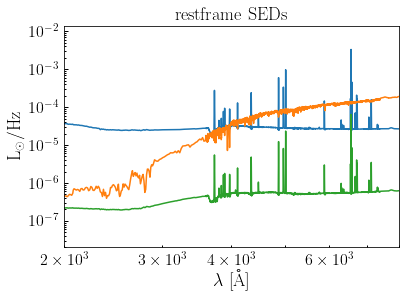

In [15]:
fig, ax = plt.subplots(1, 1)
yscale = ax.set_yscale('log')
xscale = ax.set_xscale('log')

n_plot = 3
for i in range(n_plot):
    __=ax.plot(lc_data.ssp_data.ssp_wave, sed_info.rest_sed[i, :])

xlabel = ax.set_xlabel(r'${\rm \lambda\ [\AA]}$')
ylabel = ax.set_ylabel(r'${\rm L_{\odot}/Hz}$')
title = ax.set_title(r'${\rm restframe\ SEDs}$')

xlim = ax.set_xlim(2_000, 8_000)
ymin, ymax = ax.get_ylim()
ylim = ax.set_ylim(2e-8, ymax)
